In [2]:
import pandas as pd
import numpy as np
import json
import time 

dataset_path = '../yelp-dataset/' # Change this path to match your local dataset folder path

business_filename = 'yelp_academic_dataset_business.json'
review_filename = 'yelp_academic_dataset_review.json'

# Reading business file
start = time.time()

list_business = []
categories_order = ['Beauty & Spas', 'Shopping', 'Bars']

with open(dataset_path + business_filename, 'r', encoding="utf8") as buisness_file:
    for line in buisness_file:
        json_dict = json.loads(line)
        if  json_dict['city'] == 'Toronto' and \
            json_dict['review_count'] >= 10 and \
            json_dict['categories'] is not None: # and \
            #any(word in json_dict['categories'] for word in categories_order):
                cat = [x.strip(" ") for x in json_dict['categories'].split(",")]
                if "Beauty & Spas" in cat:
                    temp_cat = "Beauty & Spas"
                    list_business.append([json_dict['business_id'], temp_cat])
                elif "Shopping" in cat:
                    temp_cat = "Shopping"
                    list_business.append([json_dict['business_id'], temp_cat])
                elif "Bars" in cat:
                    temp_cat = "Bars"
                    list_business.append([json_dict['business_id'], temp_cat]) 
                # The following line makes sure that every buisness categoy is
                # set to one of the categories_order list in that specific order.
                # temp_cat = [cat for cat in categories_order if cat in json_dict['categories']][0]
                # list_business.append([json_dict['business_id'], temp_cat])

stop = time.time()
print("Read file in {:.3f} seconds".format(stop-start))

df_buisness = pd.DataFrame(list_business, columns=['business_id', 'categories'])
display(df_buisness.head())
print('{} businesses in df_buisness'.format(df_buisness['business_id'].size))

Read file in 3.101 seconds


,business_id,categories
0,cicPsia8Wj-DNRkmLbD_xg,Bars
1,xVXyrTWbG8U3szze-aA7eg,Bars
2,e-tRKAC-q40SqQfAOwYa-A,Beauty & Spas
3,C9keC4mWuXdl2mYFHZXudQ,Shopping
4,PFS9kf3U-ZCvpqay3AaNnQ,Shopping


2991 businesses in df_buisness


In [3]:
# Extracting unique buisness ids
np_businesses = np.array(list_business)
np_businesses_ids = np_businesses[:,0]
np_businesses_ids

array(['cicPsia8Wj-DNRkmLbD_xg', 'xVXyrTWbG8U3szze-aA7eg',
       'e-tRKAC-q40SqQfAOwYa-A', ..., 'wjqOdj0XJUDOOtU9LjRlWQ',
       'AqpB2IoLkUupDCuH-hmVdg', '0hudPyuCBlKg79OwKBw-eQ'], dtype='<U22')

In [4]:
def find_buisness_index(business_id):
    index = np.where(np_businesses_ids == business_id)[0]
    return index

# Reading reveiws file
start = time.time()
business_reviews = [[] for i in range(int(len(np_businesses_ids)))]

with open(dataset_path + review_filename, 'r', encoding="utf8") as reviews_file:
    for line in reviews_file:
        json_dict = json.loads(line)
        index = find_buisness_index(json_dict['business_id'])
        if index.size > 0:
            if len(business_reviews[index[0]]) == 0:
                business_reviews[index[0]] = json_dict['text']
            else:
                business_reviews[index[0]] += json_dict['text']

stop = time.time()
print("Read file in {:.3f} mins".format((stop-start)/60))

Read file in 9.488 mins


In [5]:
df_business_reviews = pd.DataFrame(business_reviews, columns=['reviews as a single string for each buisness'])
df_business_reviews

,reviews as a single string for each buisness
0,"Consistently good, as the Keg tends to be.\n\n..."
1,I would give zero stars. I came here with a gr...
2,A blissful experience! I highly recommended th...
3,If you're a boy and you want to wear some hot ...
4,"As a country girl, I often find myself missing..."
...,...
2986,Good tacos in the downtown core are hard to co...
2987,This used to be my favourite place. It was alw...
2988,Very welcoming place. Great setup and super fr...
2989,I can't beleive I am saying this... but I left...


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

# Load custom stopwords 
# source: https://github.com/kavgan/nlp-in-practice/blob/master/tf-idf/resources/stopwords.txt
with open('stopwords.txt', 'r') as text_file:
    lines = text_file.read().split('\n')

stop_words = text.ENGLISH_STOP_WORDS.union(lines)

# Allowing words that are alpharithmetics more than 2 chars, excluding
# common words that exist in more than max_df of docs and rare words that
# exist in less than min_df of docs.
tfidf = TfidfVectorizer(min_df=0.25,
                        max_df=0.85,
                        max_features=8000,
                        token_pattern=r'(?u)\b[A-Za-z][A-Za-z]+\b',
                        lowercase=True,
                        stop_words=stop_words)


In [7]:
# True values table: Μatching categories to numbers
true_labels = np_businesses[:,1]
for i in range(len(true_labels)):
    if true_labels[i]=='Bars':
        true_labels[i]=0
    if true_labels[i]=='Beauty & Spas':
        true_labels[i]=1
    if true_labels[i]=='Shopping':
        true_labels[i]=2
    
true_labels = [int(i) for i in true_labels] 

In [8]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 5,shuffle = True)

input_train = [] # X
input_test = []  # X_test
output_train = [] # y
output_test = []

for train_index, test_index in kf.split(business_reviews):
    for i in range(len(train_index)):
        input_train.append(business_reviews[train_index[i]])
        output_train.append(np.asarray(true_labels)[train_index[i]])

    for i in range(len(test_index)):
        input_test.append(business_reviews[test_index[i]])
        output_test.append(np.asarray(true_labels)[test_index[i]])

        
input_train =  [input_train[0:2392], input_train[2392:4785], input_train[4785:7178],
               input_train[7178:9571], input_train[9571:]]
output_train = [output_train[0:2392], output_train[2392:4785], output_train[4785:7178],
                output_train[7178:9571], output_train[9571:]]

input_test = [input_test[0:599], input_test[599:1197], input_test[1197:1795],
              input_test[1795:2393], input_test[2393:]]
output_test =[output_test[0:599], output_test[599:1197], output_test[1197:1795],
              output_test[1795:2393], output_test[2393:]]

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

def display_confusion_matrix(title, cfm_data):
    plt.title(title)
    plt.axis('square')
    sns.heatmap(cfm_data, annot=True, cmap='Blues', 
                cbar=False, fmt='.1f')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

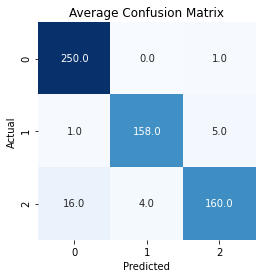

Average accuracy is 0.9515223253918181
Average F1 Score is 0.9509948008367457
Average Precision Score is 0.9523896526970456
Average recall score is 0.9515223253918181


In [27]:
# Importing the libraries
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

average_acc = 0
average_f1 = 0 
average_precision = 0
average_recall = 0
average_conf_matrix = np.zeros([3,3])

for i in range(5):
    
    X = tfidf.fit_transform(input_train[i])
    X_test = tfidf.transform(input_test[i])
    
    classifier = KNeighborsClassifier(n_neighbors = 5, p=2) #Euclidean distance
    classifier = classifier.fit(X, output_train[i])
    
    y_pred = classifier.predict(X_test)
    
    average_conf_matrix += confusion_matrix(output_test[i], y_pred)
    average_acc += accuracy_score(output_test[i], y_pred)
    average_f1 += f1_score(output_test[i], y_pred, average='weighted')
    average_precision += precision_score(output_test[i], y_pred, average='weighted')
    average_recall += recall_score(output_test[i], y_pred, average='weighted')

display_confusion_matrix("Average Confusion Matrix", average_conf_matrix//5)
print("Average accuracy is", average_acc/5)
print("Average F1 Score is", average_f1/5)
print("Average Precision Score is", average_precision/5)
print("Average recall score is", average_recall/5)

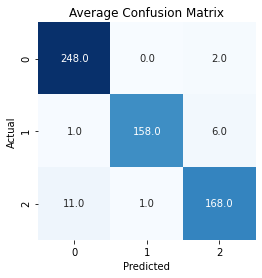

Average accuracy is 0.9622218748080691
Average F1 Score is 0.9621287152497555
Average Precision Score is 0.9626131938455534
Average recall score is 0.9622218748080691


In [28]:
from sklearn.svm import SVC

average_acc = 0
average_f1 = 0 
average_precision = 0
average_recall = 0
average_conf_matrix = np.zeros([3,3])

for i in range(5):
    
    X = tfidf.fit_transform(input_train[i])
    X_test = tfidf.transform(input_test[i])
    svm = SVC(kernel='rbf', gamma='scale') # Gaussian Kernel
    svm = svm.fit(X, output_train[i])
    
    y_pred = svm.predict(X_test)
    
    average_conf_matrix += confusion_matrix(output_test[i], y_pred)
    average_acc += accuracy_score(output_test[i], y_pred)
    average_f1 += f1_score(output_test[i], y_pred, average='weighted')
    average_precision += precision_score(output_test[i], y_pred, average='weighted', zero_division=0)
    average_recall += recall_score(output_test[i], y_pred, average='weighted')
    
display_confusion_matrix("Average Confusion Matrix", average_conf_matrix//5)
print("Average accuracy is", average_acc/5)
print("Average F1 Score is", average_f1/5)
print("Average Precision Score is", average_precision/5)
print("Average recall score is", average_recall/5)

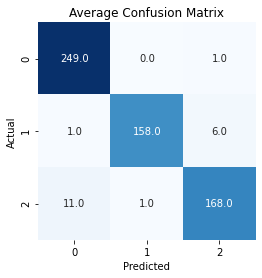

Average accuracy is 0.963226894322198
Average F1 Score is 0.9630753738245751
Average Precision Score is 0.9636212593007647
Average recall score is 0.963226894322198


In [29]:
from sklearn.svm import SVC

average_acc = 0
average_f1 = 0 
average_precision = 0
average_recall = 0
average_conf_matrix = np.zeros([3,3])

for i in range(5):
    
    X = tfidf.fit_transform(input_train[i])
    X_test = tfidf.transform(input_test[i])
    svm = SVC(kernel='linear', gamma='scale') # Linear Kernel
    svm = svm.fit(X, output_train[i])
    
    y_pred = svm.predict(X_test)
    
    average_conf_matrix += confusion_matrix(output_test[i], y_pred)
    average_acc += accuracy_score(output_test[i], y_pred)
    average_f1 += f1_score(output_test[i], y_pred, average='weighted')
    average_precision += precision_score(output_test[i], y_pred, average='weighted', zero_division=0)
    average_recall += recall_score(output_test[i], y_pred, average='weighted')

display_confusion_matrix("Average Confusion Matrix", average_conf_matrix//5)
print("Average accuracy is", average_acc/5)
print("Average F1 Score is", average_f1/5)
print("Average Precision Score is", average_precision/5)
print("Average recall score is", average_recall/5)

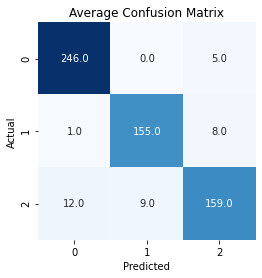

Average accuracy is 0.9384833138843447
Average F1 Score is 0.9380527459035962
Average Precision Score is 0.9383703095855284
Average recall score is 0.9384833138843447


In [30]:
from sklearn.naive_bayes import GaussianNB

average_acc = 0
average_f1 = 0 
average_precision = 0
average_recall = 0
average_conf_matrix = np.zeros([3,3])

for i in range(5):
    
    X = tfidf.fit_transform(input_train[i])
    X_test = tfidf.transform(input_test[i])
    nb = GaussianNB()
    nb = nb.fit(X.todense(), output_train[i])
    
    y_pred = nb.predict(X_test.todense())
    
    average_conf_matrix += confusion_matrix(output_test[i], y_pred)
    average_acc += accuracy_score(output_test[i], y_pred)
    average_f1 += f1_score(output_test[i], y_pred, average='weighted')
    average_precision += precision_score(output_test[i], y_pred, average='weighted', zero_division=0)
    average_recall += recall_score(output_test[i], y_pred, average='weighted')

display_confusion_matrix("Average Confusion Matrix", average_conf_matrix//5)
print("Average accuracy is", average_acc/5)
print("Average F1 Score is", average_f1/5)
print("Average Precision Score is", average_precision/5)
print("Average recall score is", average_recall/5)

In [31]:
# We use LBFGS algorithm for optimization or newton-cg

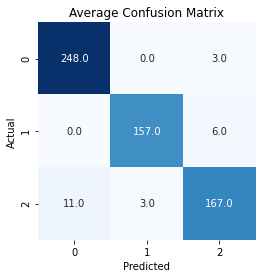

Average accuracy is 0.9585451784188809
Average F1 Score is 0.958387802599662
Average Precision Score is 0.9587666063985708
Average recall score is 0.9585451784188809


In [32]:
import sklearn.linear_model as linear_model

average_acc = 0
average_f1 = 0 
average_precision = 0
average_recall = 0
average_conf_matrix = np.zeros([3,3])

for i in range(5):
    
    X = tfidf.fit_transform(input_train[i])
    X_test = tfidf.transform(input_test[i])
    linear_clf = linear_model.LogisticRegression(solver='newton-cg')
    linear_clf.fit(X, output_train[i])
    
    y_pred = linear_clf.predict(X_test)
    
    average_conf_matrix += confusion_matrix(output_test[i], y_pred)
    average_acc += accuracy_score(output_test[i], y_pred)
    average_f1 += f1_score(output_test[i], y_pred, average='weighted')
    average_precision += precision_score(output_test[i], y_pred, average='weighted', zero_division=0)
    average_recall += recall_score(output_test[i], y_pred, average='weighted')

display_confusion_matrix("Average Confusion Matrix", average_conf_matrix//5)
print("Average accuracy is", average_acc/5)
print("Average F1 Score is", average_f1/5)
print("Average Precision Score is", average_precision/5)
print("Average recall score is", average_recall/5)

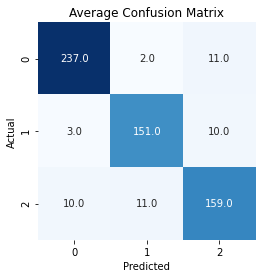

Average accuracy is 0.9164169937632958
Average F1 Score is 0.9164699380847317
Average Precision Score is 0.9167198639425539
Average recall score is 0.9164169937632958


In [33]:
from sklearn import tree

average_acc = 0
average_f1 = 0 
average_precision = 0
average_recall = 0
average_conf_matrix = np.zeros([3,3])

for i in range(5):
    
    X = tfidf.fit_transform(input_train[i])
    X_test = tfidf.transform(input_test[i])
    decision_tree = tree.DecisionTreeClassifier()
    decision_tree = decision_tree.fit(X, output_train[i])

    y_pred = decision_tree.predict(X_test)

    average_conf_matrix += confusion_matrix(output_test[i], y_pred)
    average_acc += accuracy_score(output_test[i], y_pred)
    average_f1 += f1_score(output_test[i], y_pred, average='weighted')
    average_precision += precision_score(output_test[i], y_pred, average='weighted', zero_division=0)
    average_recall += recall_score(output_test[i], y_pred, average='weighted')

display_confusion_matrix("Average Confusion Matrix", average_conf_matrix//5)
print("Average accuracy is", average_acc/5)
print("Average F1 Score is", average_f1/5)
print("Average Precision Score is", average_precision/5)
print("Average recall score is", average_recall/5)



It might be a coincidence.

If we have to say something about it, then it indicates that sensitivity (a.k.a. recall, or TPR) is equal to specificity (a.k.a. selectivity, or TNR), and thus they are also equal to accuracy. TP / P = TN / N = (TP+TN) / (P+N), where P = TP+FN, N = TN+FP.

This means your model is somehow "balanced", that is, its ability to correctly classify positive samples is same as its ability to correctly classify negative samples.

However, the importance of sensitivity and specificity may vary from case to case, so being "balanced" is not necessarily good.





As OP has mentioned, this is just a coincidence. It's highly likely that number of instances in each class is balanced. Recall = TP/P and Acc = (TP + TN)/(P+N), so in your case TP/P = TN/N. This can happen, and is more likely to happen when |P| = |N|

Try following: Print upto 7-8 places of decimal and you may see some difference.

Second try to imbalance the problem. Like set positive class as just 20% of total and let rest be 80%, you should definitely see the difference.




As OP has mentioned, this is just a coincidence. It's highly likely that number of instances in each class is balanced. Recall = TP/P and Acc = (TP + TN)/(P+N), so in your case TP/P = TN/N. This can happen, and is more likely to happen when |P| = |N|

Try following: Print upto 7-8 places of decimal and you may see some difference.

Second try to imbalance the problem. Like set positive class as just 20% of total and let rest be 80%, you should definitely see the difference.




## ΕΡΩΤΗΜΑ Β

In [34]:
import gensim

filepath = '/home/left/github/data-mining-3/GoogleNews-vectors-negative300.bin'
g_model = gensim.models.KeyedVectors.load_word2vec_format(filepath, binary=True)

ModuleNotFoundError: No module named 'gensim'

In [389]:
X_news_train_gmodel = []
for x in business_reviews[0]:
    vx = np.zeros(300)
    length = 0
    for w in x: 
        if w in g_model.wv:
            length += 1
            vx += g_model[w]
    if length != 0: vx /= length
    X_news_train_gmodel.append(vx)

<ipython-input-389-9958a3d4c933>:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if w in g_model.wv:


In [390]:
X_news_test_gmodel = []
for x in business_reviews[0]:
    vx = np.zeros(300)
    length = 0
    for w in x: 
        if (w not in g_model.wv): continue
        length += 1
        vx += g_model.wv[w]
    if length != 0: vx /= length
    X_news_test_gmodel.append(vx)

<ipython-input-390-8c985c83a0ef>:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if (w not in g_model.wv): continue
<ipython-input-390-8c985c83a0ef>:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  vx += g_model.wv[w]
